In [1]:
%pip install yfinance

  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     - -------------------------------------- 0.1/3.0 MB 4.3 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/3.0 MB 6.7 MB/s eta 0:00:01
     ------------ --------------------------- 0.9/3.0 MB 7.3 MB/s eta 0:00:01
     ------------------- -------------------- 1.5/3.0 MB 8.4 MB/s eta 0:00:01
     --------------------------- ------------ 2.1/3.0 MB 9.4 MB/s eta 0:00:01
     ------------------------------- -------- 2.4/3.0 MB 9.0 MB/s eta 0:00:01
     --------------------------------- ------ 2.6/3.0 MB 8.2 MB/s eta 0:00:01
   

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Data Import and Exploration - Is it normal or not ? 

## 1.1 From 2005 to 2025


Summary Statistics:
count    5032.000000
mean        0.000316
std         0.012104
min        -0.127652
25%        -0.004093
50%         0.000711
75%         0.005705
max         0.109572
Name: Return, dtype: float64


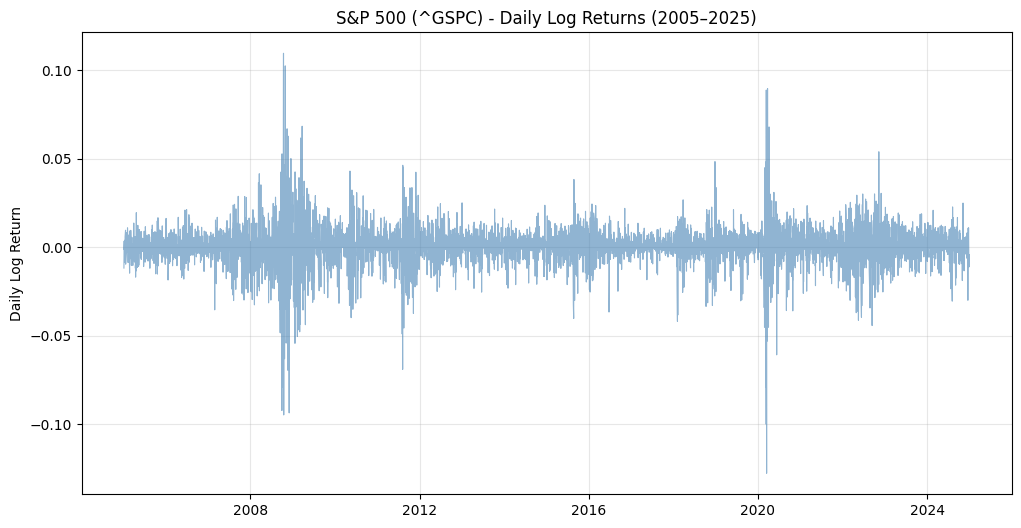

In [3]:
# 1. Define parameters
ticker = "^GSPC" 
start_date = "2005-01-01"
end_date = "2025-01-01"

# 2. Download daily data
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=False)

# Convert columns from ('Adj Close', '^GSPC') -> 'Adj Close'
data.columns = data.columns.get_level_values(0)

# 3. Compute daily log returns
data["Return"] = np.log(data["Adj Close"] / data["Adj Close"].shift(1))

# Drop the first row (NaN)
data = data.dropna(subset=["Return"])

# 4. Summary stats
print("\nSummary Statistics:")
print(data["Return"].describe())

# 5. Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data["Return"], color="steelblue", alpha=0.6, linewidth=0.8)
plt.title(f"S&P 500 ({ticker}) - Daily Log Returns (2005–2025)")
plt.ylabel("Daily Log Return")
plt.grid(True, alpha=0.3)
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\m'
<>:21: SyntaxWarning: invalid escape sequence '\s'
C:\Users\gerry\AppData\Local\Temp\ipykernel_24220\1820506516.py:21: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')
C:\Users\gerry\AppData\Local\Temp\ipykernel_24220\1820506516.py:21: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')


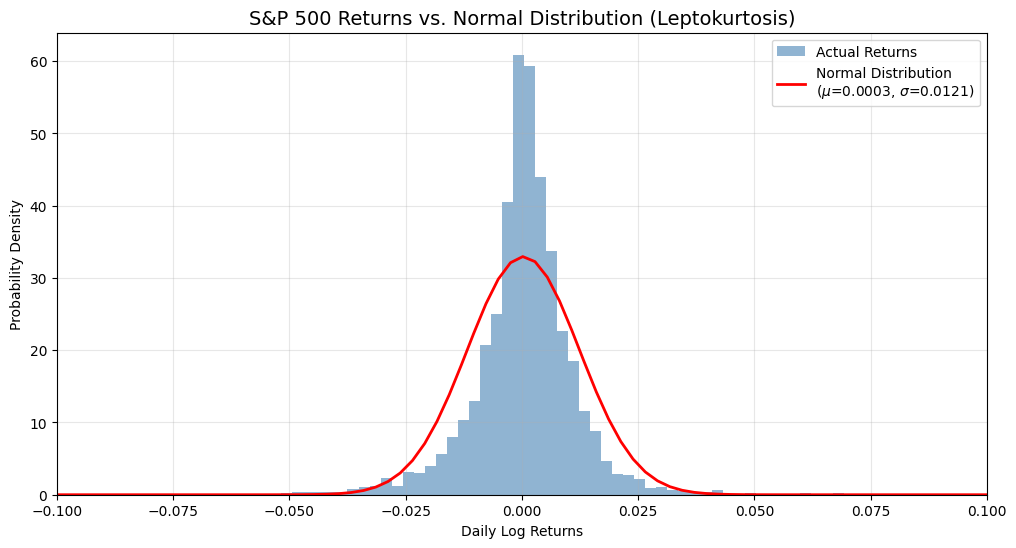

In [5]:
from scipy.stats import norm  # Essential for the Normal distribution

# 1. Fit the Normal Distribution to your data
# This calculates the Mean (mu) and Standard Deviation (std) of your returns
mu, std = norm.fit(data["Return"])

# 2. Setup the Plot
plt.figure(figsize=(12, 6))

# 3. Plot the Histogram of Actual Returns
# density=True is MANDATORY. It normalizes the counts so they match the scale of the probability curve.
plt.hist(data["Return"], bins=100, density=True, alpha=0.6, color='steelblue', label='Actual Returns')

# 4. Plot the Theoretical Normal Distribution
# Create a range of x values from the min to max of your data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
# Generate the "Bell Curve" y-values
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')

# 5. Formatting
plt.title("S&P 500 Returns vs. Normal Distribution (Leptokurtosis)", fontsize=14)
plt.xlabel("Daily Log Returns")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Zoom in slightly to see the "Peak" better (Financial data often has extreme outliers)
# You can comment this out to see the full width
plt.xlim(-0.10, 0.10) 

plt.show()

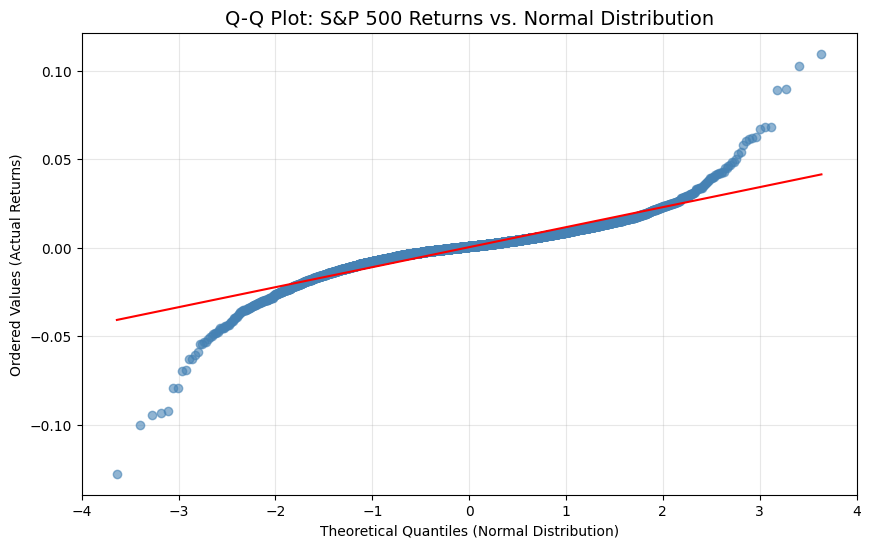

In [6]:
import scipy.stats as stats

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Generate the Q-Q Plot
# dist="norm" tells scipy to compare your data against a Normal distribution
# plot=plt tells it to draw directly on our matplotlib figure
stats.probplot(data["Return"], dist="norm", plot=plt)

# 3. Customization for the Report
plt.title("Q-Q Plot: S&P 500 Returns vs. Normal Distribution", fontsize=14)
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Ordered Values (Actual Returns)")
plt.grid(True, alpha=0.3)

# Optional: Change the color of the dots to make it distinct
ax = plt.gca()
ax.get_lines()[0].set_markerfacecolor('steelblue')
ax.get_lines()[0].set_markeredgecolor('steelblue')
ax.get_lines()[0].set_alpha(0.6)

plt.show()

Extreme Threshold: 0.0337 (approx 3.37%)
Any daily move larger than this is considered a 'Black Swan' event.
Number of Extreme Days found: 101 out of 5032 days


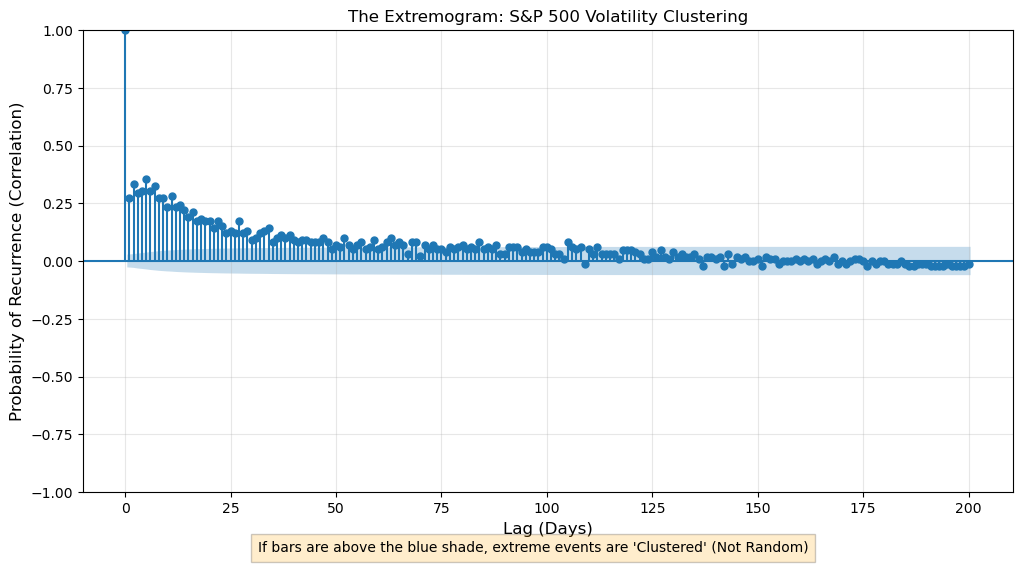

In [20]:
from statsmodels.graphics.tsaplots import plot_acf

# ==========================================
# STEP 1: Define "Extreme" (The Setup)
# ==========================================

# We take the Absolute Value because volatility is about magnitude.
# A +5% jump is just as "extreme" and destabilizing as a -5% crash.
abs_returns = data["Return"].abs()

# We set the Threshold at the 98th percentile (Top 2% of most volatile days)
# This is a standard choice in the literature (Reference: Davis & Mikosch).
threshold = abs_returns.quantile(0.98)

print(f"Extreme Threshold: {threshold:.4f} (approx {threshold*100:.2f}%)")
print(f"Any daily move larger than this is considered a 'Black Swan' event.")

# ==========================================
# STEP 2: Create the "Hit Sequence"
# ==========================================

# Convert returns to a binary series:
# 1 = Extreme Event (The return exceeded the threshold)
# 0 = Normal Day
extreme_hits = (abs_returns > threshold).astype(int)

# Check how many extremes we found
print(f"Number of Extreme Days found: {extreme_hits.sum()} out of {len(extreme_hits)} days")

# ==========================================
# STEP 3: Plot the Extremogram
# ==========================================

plt.figure(figsize=(12, 6))

# We use the Autocorrelation Function (ACF) on the binary data.
# lags=50: We look at the relationship over the next 50 days.
# alpha=0.05: Draws the 95% confidence interval (the blue shaded region).
plot_acf(extreme_hits, lags=200, alpha=0.05, title="The Extremogram: S&P 500 Volatility Clustering", ax=plt.gca())

# Formatting for the report
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Probability of Recurrence (Correlation)", fontsize=12)
plt.grid(True, alpha=0.3)

# Add a note explaining the graph directly on the plot
plt.figtext(0.5, 0.01, "If bars are above the blue shade, extreme events are 'Clustered' (Not Random)", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.show()

While Part 1 showed that market returns are not normally distributed and exhibit heavy tails, the extremogram reveals something equally critical: extreme events are not isolated. By analyzing the autocorrelation of the most volatile 2% of days, we find statistically significant dependence across short time lags—meaning that once an extreme move occurs, the probability of another extreme event in the following days is meaningfully higher than average. This pattern of tail dependence contradicts the assumptions of i.i.d. Gaussian returns and strongly suggests that risk is time-varying. It also mirrors real-world market behavior during crises, where volatility arrives in clusters. This empirical evidence motivates a shift toward dynamic models like GARCH, which explicitly capture time-varying volatility, and supports the use of heavy-tailed innovations to model extreme outcomes more realistically. We now turn to Part 2, where we implement such a model to forecast tail risk in the S&P 500.

## 1.2. The 2008 crisis - Data from 2008 to 2010

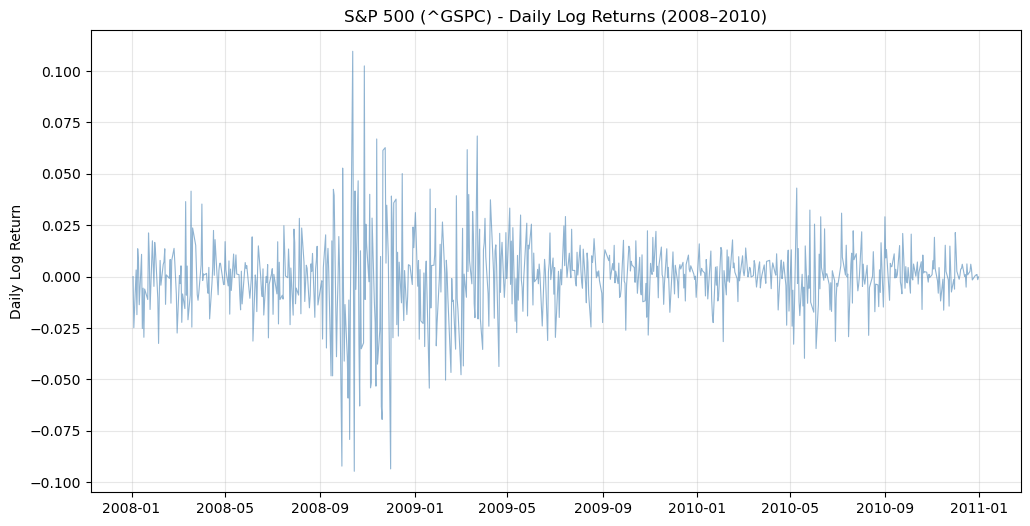

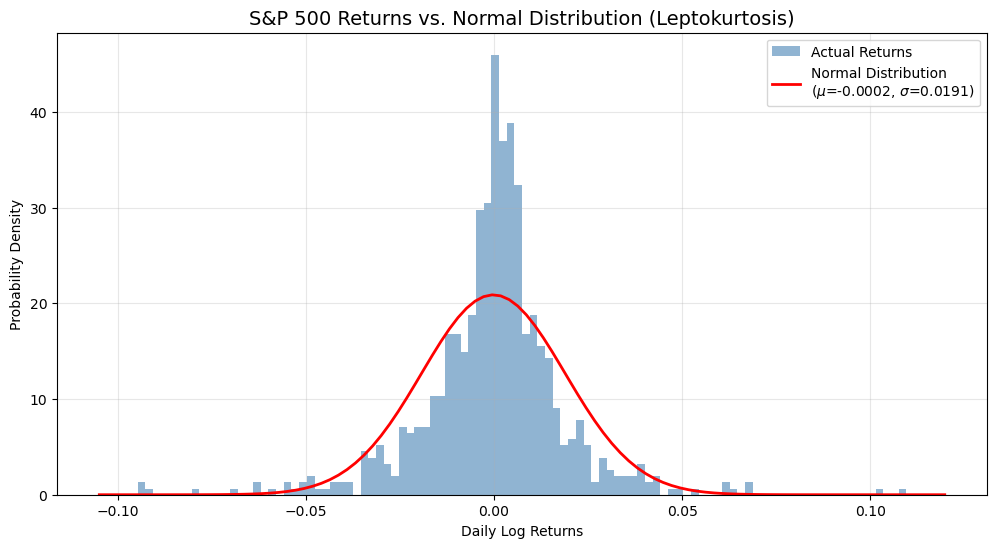

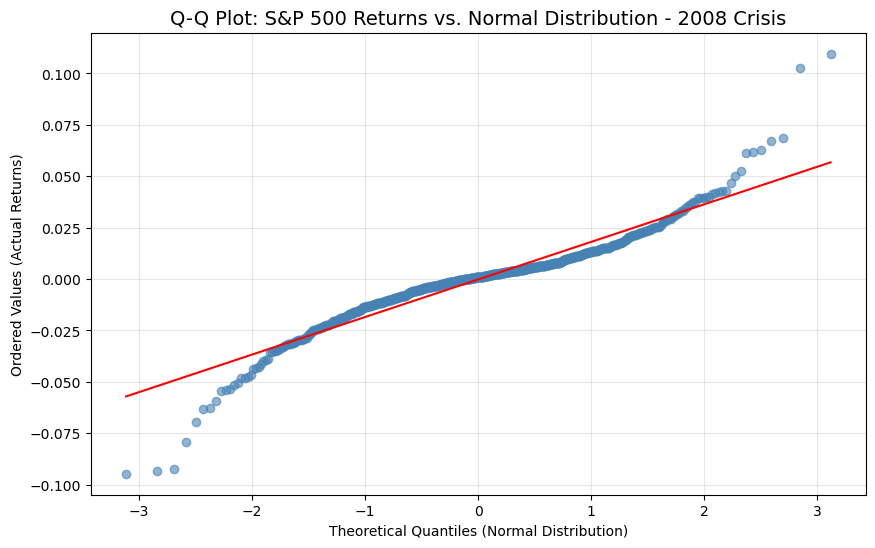

Extreme Threshold: 0.0542 (approx 5.42%)
Any daily move larger than this is considered a 'Black Swan' event.
Number of Extreme Days found: 16 out of 756 days


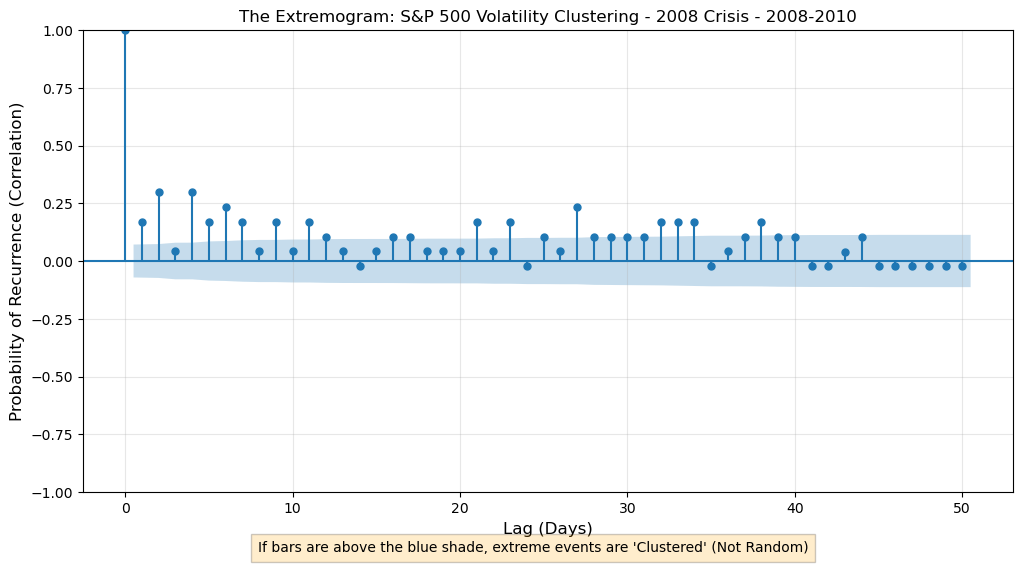

In [21]:
# 1. Download daily data
data_2008 = yf.download(ticker, start="2008-01-01", end="2011-01-01", progress=False, auto_adjust=False)

# Convert columns from ('Adj Close', '^GSPC') -> 'Adj Close'
data_2008.columns = data_2008.columns.get_level_values(0)

# 3. Compute daily log returns
data_2008["Return"] = np.log(data_2008["Adj Close"] / data_2008["Adj Close"].shift(1))

# Drop the first row (NaN)
data_2008 = data_2008.dropna(subset=["Return"])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_2008.index, data_2008["Return"], color="steelblue", alpha=0.6, linewidth=0.8)
plt.title(f"S&P 500 ({ticker}) - Daily Log Returns (2008–2010)")
plt.ylabel("Daily Log Return")
plt.grid(True, alpha=0.3)
plt.show()

# 1. Fit the Normal Distribution to your data
# This calculates the Mean (mu) and Standard Deviation (std) of your returns
mu, std = norm.fit(data_2008["Return"])

# 2. Setup the Plot
plt.figure(figsize=(12, 6))

# 3. Plot the Histogram of Actual Returns
# density=True is MANDATORY. It normalizes the counts so they match the scale of the probability curve.
plt.hist(data_2008["Return"], bins=100, density=True, alpha=0.6, color='steelblue', label='Actual Returns')

# 4. Plot the Theoretical Normal Distribution
# Create a range of x values from the min to max of your data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
# Generate the "Bell Curve" y-values
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')

# 5. Formatting
plt.title("S&P 500 Returns vs. Normal Distribution (Leptokurtosis)", fontsize=14)
plt.xlabel("Daily Log Returns")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Zoom in slightly to see the "Peak" better (Financial data often has extreme outliers)
# You can comment this out to see the full width
#plt.xlim(-0.10, 0.10) 

plt.show()

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Generate the Q-Q Plot
# dist="norm" tells scipy to compare your data against a Normal distribution
# plot=plt tells it to draw directly on our matplotlib figure
stats.probplot(data_2008["Return"], dist="norm", plot=plt)

# 3. Customization for the Report
plt.title("Q-Q Plot: S&P 500 Returns vs. Normal Distribution - 2008 Crisis", fontsize=14)
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Ordered Values (Actual Returns)")
plt.grid(True, alpha=0.3)

# Optional: Change the color of the dots to make it distinct
ax = plt.gca()
ax.get_lines()[0].set_markerfacecolor('steelblue')
ax.get_lines()[0].set_markeredgecolor('steelblue')
ax.get_lines()[0].set_alpha(0.6)

plt.show()

# ==========================================
# STEP 1: Define "Extreme" (The Setup)
# ==========================================

# We take the Absolute Value because volatility is about magnitude.
# A +5% jump is just as "extreme" and destabilizing as a -5% crash.

abs_returns = data_2008["Return"].abs()

# We set the Threshold at the 98th percentile (Top 2% of most volatile days)
# This is a standard choice in the literature (Reference: Davis & Mikosch).
threshold = abs_returns.quantile(0.98)

print(f"Extreme Threshold: {threshold:.4f} (approx {threshold*100:.2f}%)")
print(f"Any daily move larger than this is considered a 'Black Swan' event.")

# ==========================================
# STEP 2: Create the "Hit Sequence"
# ==========================================

# Convert returns to a binary series:
# 1 = Extreme Event (The return exceeded the threshold)
# 0 = Normal Day
extreme_hits = (abs_returns > threshold).astype(int)

# Check how many extremes we found
print(f"Number of Extreme Days found: {extreme_hits.sum()} out of {len(extreme_hits)} days")

# ==========================================
# STEP 3: Plot the Extremogram
# ==========================================

plt.figure(figsize=(12, 6))

# We use the Autocorrelation Function (ACF) on the binary data.
# lags=50: We look at the relationship over the next 50 days.
# alpha=0.05: Draws the 95% confidence interval (the blue shaded region).
plot_acf(extreme_hits, lags=50, alpha=0.05, title="The Extremogram: S&P 500 Volatility Clustering - 2008 Crisis - 2008-2010", ax=plt.gca())

# Formatting for the report
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Probability of Recurrence (Correlation)", fontsize=12)
plt.grid(True, alpha=0.3)

# Add a note explaining the graph directly on the plot
plt.figtext(0.5, 0.01, "If bars are above the blue shade, extreme events are 'Clustered' (Not Random)", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.show()

## 1.3. Covid Crisis - From 2020 to 2022

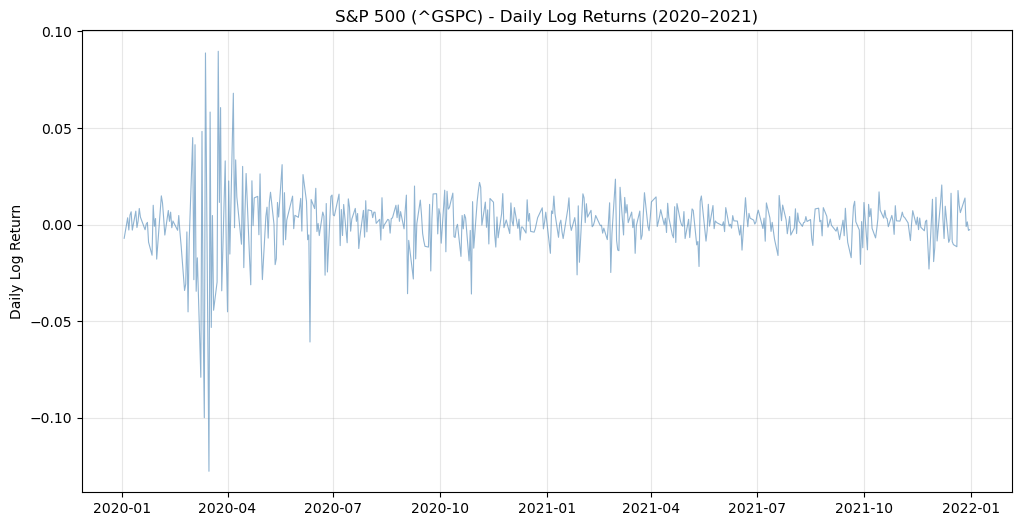

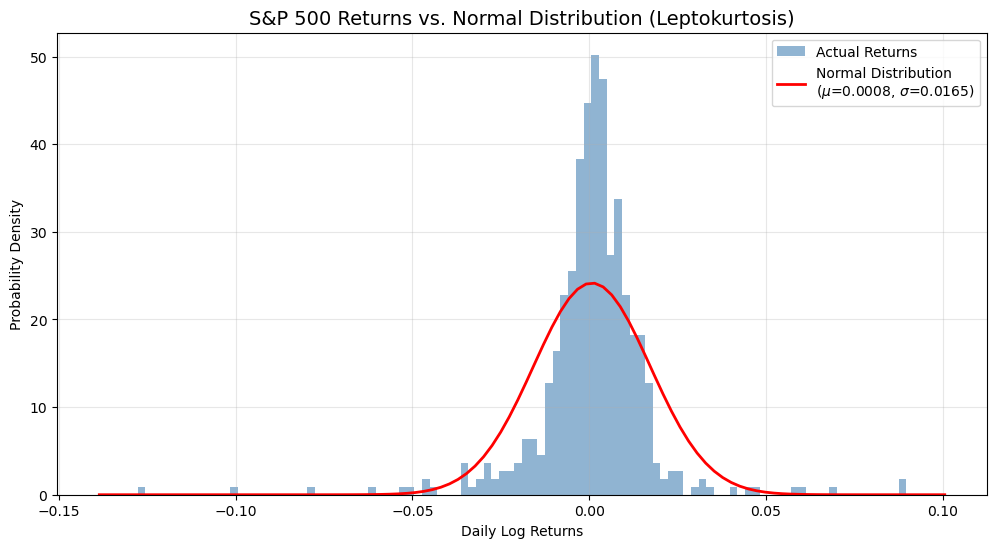

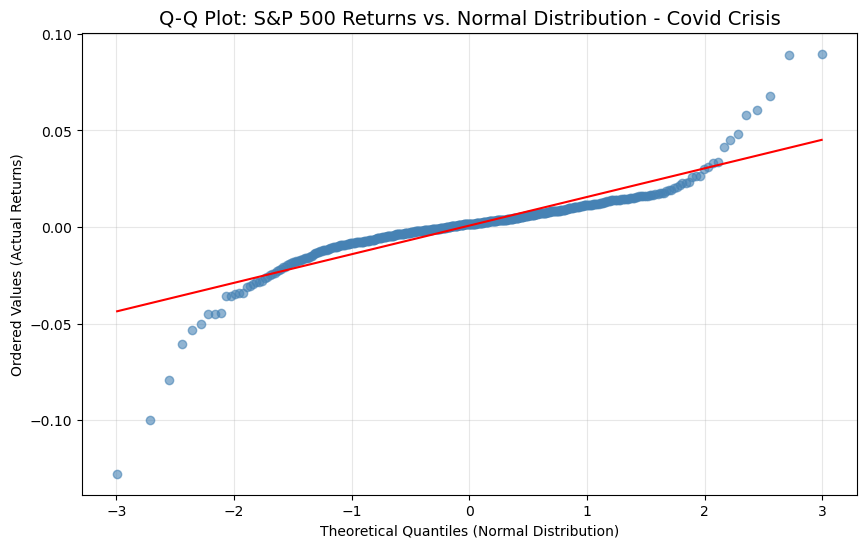

Extreme Threshold: 0.0500 (approx 5.00%)
Any daily move larger than this is considered a 'Black Swan' event.
Number of Extreme Days found: 11 out of 504 days


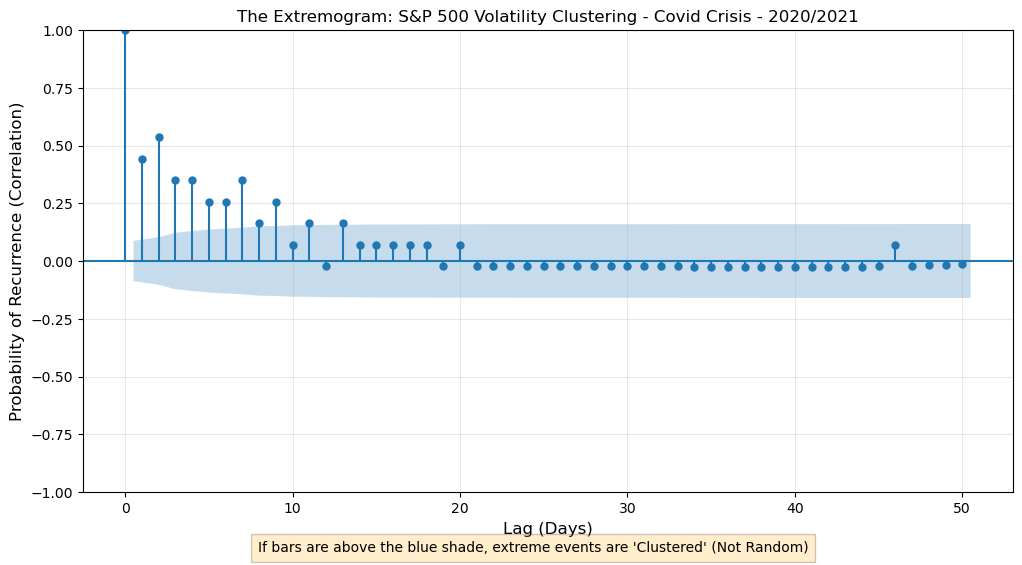

In [22]:
# 1. Download daily data
data_2020 = yf.download(ticker, start="2020-01-01", end="2022-01-01", progress=False, auto_adjust=False)

# Convert columns from ('Adj Close', '^GSPC') -> 'Adj Close'
data_2020.columns = data_2020.columns.get_level_values(0)

# 3. Compute daily log returns
data_2020["Return"] = np.log(data_2020["Adj Close"] / data_2020["Adj Close"].shift(1))

# Drop the first row (NaN)
data_2020 = data_2020.dropna(subset=["Return"])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data_2020.index, data_2020["Return"], color="steelblue", alpha=0.6, linewidth=0.8)
plt.title(f"S&P 500 ({ticker}) - Daily Log Returns (2020–2021)")
plt.ylabel("Daily Log Return")
plt.grid(True, alpha=0.3)
plt.show()

# 1. Fit the Normal Distribution to your data
# This calculates the Mean (mu) and Standard Deviation (std) of your returns
mu, std = norm.fit(data_2020["Return"])

# 2. Setup the Plot
plt.figure(figsize=(12, 6))

# 3. Plot the Histogram of Actual Returns
# density=True is MANDATORY. It normalizes the counts so they match the scale of the probability curve.
plt.hist(data_2020["Return"], bins=100, density=True, alpha=0.6, color='steelblue', label='Actual Returns')

# 4. Plot the Theoretical Normal Distribution
# Create a range of x values from the min to max of your data
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
# Generate the "Bell Curve" y-values
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'r', linewidth=2, label=f'Normal Distribution\n($\mu$={mu:.4f}, $\sigma$={std:.4f})')

# 5. Formatting
plt.title("S&P 500 Returns vs. Normal Distribution (Leptokurtosis)", fontsize=14)
plt.xlabel("Daily Log Returns")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: Zoom in slightly to see the "Peak" better (Financial data often has extreme outliers)
# You can comment this out to see the full width
#plt.xlim(-0.10, 0.10) 

plt.show()

# 1. Setup the Plot
plt.figure(figsize=(10, 6))

# 2. Generate the Q-Q Plot
# dist="norm" tells scipy to compare your data against a Normal distribution
# plot=plt tells it to draw directly on our matplotlib figure
stats.probplot(data_2020["Return"], dist="norm", plot=plt)

# 3. Customization for the Report
plt.title("Q-Q Plot: S&P 500 Returns vs. Normal Distribution - Covid Crisis", fontsize=14)
plt.xlabel("Theoretical Quantiles (Normal Distribution)")
plt.ylabel("Ordered Values (Actual Returns)")
plt.grid(True, alpha=0.3)

# Optional: Change the color of the dots to make it distinct
ax = plt.gca()
ax.get_lines()[0].set_markerfacecolor('steelblue')
ax.get_lines()[0].set_markeredgecolor('steelblue')
ax.get_lines()[0].set_alpha(0.6)

plt.show()

from statsmodels.graphics.tsaplots import plot_acf

# ==========================================
# STEP 1: Define "Extreme" (The Setup)
# ==========================================

# We take the Absolute Value because volatility is about magnitude.
# A +5% jump is just as "extreme" and destabilizing as a -5% crash.
abs_returns = data_2020["Return"].abs()

# We set the Threshold at the 98th percentile (Top 2% of most volatile days)
# This is a standard choice in the literature (Reference: Davis & Mikosch).
threshold = abs_returns.quantile(0.98)

print(f"Extreme Threshold: {threshold:.4f} (approx {threshold*100:.2f}%)")
print(f"Any daily move larger than this is considered a 'Black Swan' event.")

# ==========================================
# STEP 2: Create the "Hit Sequence"
# ==========================================

# Convert returns to a binary series:
# 1 = Extreme Event (The return exceeded the threshold)
# 0 = Normal Day
extreme_hits = (abs_returns > threshold).astype(int)

# Check how many extremes we found
print(f"Number of Extreme Days found: {extreme_hits.sum()} out of {len(extreme_hits)} days")

# ==========================================
# STEP 3: Plot the Extremogram
# ==========================================

plt.figure(figsize=(12, 6))

# We use the Autocorrelation Function (ACF) on the binary data.
# lags=50: We look at the relationship over the next 50 days.
# alpha=0.05: Draws the 95% confidence interval (the blue shaded region).
plot_acf(extreme_hits, lags=50, alpha=0.05, title="The Extremogram: S&P 500 Volatility Clustering - Covid Crisis - 2020/2021", ax=plt.gca())

# Formatting for the report
plt.xlabel("Lag (Days)", fontsize=12)
plt.ylabel("Probability of Recurrence (Correlation)", fontsize=12)
plt.grid(True, alpha=0.3)

# Add a note explaining the graph directly on the plot
plt.figtext(0.5, 0.01, "If bars are above the blue shade, extreme events are 'Clustered' (Not Random)", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.show()